In [1]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np

% matplotlib inline

In [12]:
N = 100; Ne = int( 0.8*N ); Ni = int( 0.2*N );

T = np.linspace(0,4,4000,endpoint=False) # time in ms

J0 = 0.3; J1 = 0.4; l = 0.2
sigma = 1.8

# i-d array, storing the position of each neuron
positions = np.linspace(0,1,N,endpoint=False)

# pre-define Jij_ex
Jij_ex = np.zeros([N, N])

In [3]:
def sigmoid(x):
    z = 1 / (1 + np.exp(-x))
    return z

In [4]:
# Equ. 8
def sigma_ij_comp(i,j,sigma):
    if i<j:
        result = 1
    else:
        result = sigma
    return result

In [5]:
def Jij_ex_comp(i, j):
    sigma_ij = sigma_ij_comp(i,j,sigma)
    result = sigma_ij * J1 * np.exp(-np.abs(positions[i]-positions[j])/l)
    return result

In [6]:
# compute each element of Jij_ex, treat Jij as a constant matrix
for ii in range(N):
    for jj in range(N):
        Jij_ex[ii,jj] = Jij_ex_comp(ii,jj)
    
Jij_ex

array([[0.72      , 0.38049177, 0.36193497, ..., 0.00313135, 0.00297863,
        0.00283336],
       [0.68488519, 0.72      , 0.38049177, ..., 0.0032919 , 0.00313135,
        0.00297863],
       [0.65148294, 0.68488519, 0.72      , ..., 0.00346068, 0.0032919 ,
        0.00313135],
       ...,
       [0.00563643, 0.00592542, 0.00622922, ..., 0.72      , 0.38049177,
        0.36193497],
       [0.00536154, 0.00563643, 0.00592542, ..., 0.68488519, 0.72      ,
        0.38049177],
       [0.00510005, 0.00536154, 0.00563643, ..., 0.65148294, 0.68488519,
        0.72      ]])

In [7]:
x0 = T/len(T)
I0 = 1.02
lambda_e = 0.03
lambda_i = 0.02
Vres = 0.85
theta = 1
J2 = 0.02
s_ex = 0.2
s_in = 0.7

In [9]:
# Equ. 9
I_ext_ex = np.zeros([Ne, len(T)])

for i in range(Ne):
    for t in range(len(T)):
        I_ext_ex[i,t] = I0 * (1 + lambda_e*np.exp(-np.abs(positions[i]-x0[t])/l))
I_ext_ex

array([[1.0506    , 1.05059996, 1.05059992, ..., 1.0504475 , 1.05044746,
        1.05044742],
       [1.04910762, 1.04910766, 1.04910769, ..., 1.04925341, 1.04925345,
        1.04925349],
       [1.04768802, 1.04768806, 1.04768809, ..., 1.04782671, 1.04782674,
        1.04782678],
       ...,
       [1.02065116, 1.02065116, 1.02065116, ..., 1.02065442, 1.02065442,
        1.02065442],
       [1.0206194 , 1.0206194 , 1.0206194 , ..., 1.0206225 , 1.02062251,
        1.02062251],
       [1.02058919, 1.02058919, 1.0205892 , ..., 1.02059215, 1.02059215,
        1.02059215]])

In [15]:
# Equ. 10
I_ext_in = np.zeros(len(T))

for t in range(len(T)):
    I_ext_in[t] = I0 * (1 + lambda_i * np.cos(2*np.pi*T[t]*6)) # 6-9 Hz

I_ext_in

array([1.0404    , 1.04038551, 1.04034204, ..., 1.04026967, 1.04034204,
       1.04038551])

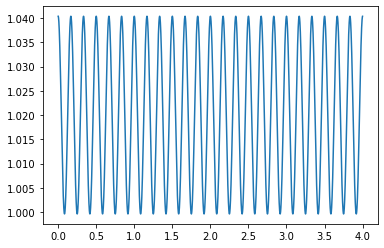

In [16]:
plt.plot(T, I_ext_in)

In [ ]:
start_scope()

# parameters
taum   = 20*ms   # time constant
g_L    = 10*nS   # leak conductance
E_l    = -70*mV  # leak reversal potential
E_e    = 0*mV    # excitatory reversal potential
tau_e  = 5*ms    # excitatory synaptic time constant
Vr     = E_l     # reset potential
Vth    = -50*mV  # spike threshold
Vs     = 20*mV   # spiking potential
w_e    = 1       # excitatory synaptic weight (units of g_L)

# model equations
eqs = '''
dv/dt = ( E_l - v + g_e*(E_e-v) ) / taum  : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : 1  # excitatory conductance (dimensionless units)
'''

# create neuron
N = NeuronGroup( 1, model=eqs, threshold='v>Vth', reset='v=Vr', refractory='5*ms', method='euler' )

# initialize neuron
N.v = E_l

# create inputs
indices = array([0, 0, 0]); times = array([25, 50, 75])*ms
input = SpikeGeneratorGroup( 1, indices, times )

# create connections
S = Synapses( input, N, 'w: 1', on_pre='g_e += w_e' )
S.connect( i=0, j=0 );

# record model state
M = StateMonitor( N, ('v','g_e'), record=True )

# run simulation
run( 10*ms )

# plot output
fig, ax1 = plt.subplots(); ax2 = ax1.twinx()
ax1.plot( M.t/ms, M.v[0] ); ax2.plot( M.t/ms, M.g_e[0], 'g--' );
ax1.set_xlabel( 'time (ms)' ); ax1.set_ylabel( 'V_m (V)' ); ax2.set_ylabel( 'g_e (units of g_L)' )

In [ ]:
M.v.shape

In [ ]:
start_scope()

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 15*Hz
wmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= wmax
dApre *= wmax

eqs_neurons = '''
dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='linear')
S = Synapses(input, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, wmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, wmax)''',
             )
S.connect()
S.w = 'rand() * wmax'

mon = StateMonitor(S, 'w', record=True) 
# the resulting ndarray will now have the shape (N,timesteps),
# which will allow accessing the time evolution of individual 
# synapses (e.g. mon.w[0] will be the time evolution of the first
# input synapse)

s_mon = SpikeMonitor(input)

run(10*second, report='text')

# subplot(311)
# plot(S.w / wmax, '.k')
# ylabel('Weight / wmax')
# xlabel('Synapse index')
# subplot(312)
# hist(S.w / wmax, 20)
# xlabel('Weight / wmax')
# subplot(313)
# plot(mon.t/second, mon.w[0]/wmax) # timecourse of synaptic weight for first input synapse
# xlabel('Time (s)')
# ylabel('Weight / wmax')

In [ ]:
subplot(311)
plot(S.w / wmax, '.k')
ylabel('Weight / wmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / wmax, 20)
xlabel('Weight / wmax')
subplot(313)
plot(mon.t/second, mon.w[0]/wmax) # timecourse of synaptic weight for first input synapse
xlabel('Time (s)')
ylabel('Weight / wmax')

In [ ]:
S.w.shape